# Sparkify POC Project Workspace
In this workspace, a tiny subset (128 MB) of the full sparkify dataset is Explored.

The main purpose of this workspace is to setup a working Spark flow, which can be used on a AWS cluster which will analyse the full dataset. In the process, the following steps will be walked through:

- Load Libaries and the Mini Dataset into a local Spark session
- Clean Dataset
-  Set up a working Spark flow which can be used on the la


# Load Libaries and Data

In [26]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier
from sklearn.metrics import confusion_matrix

from pyspark.sql import Window
from pyspark.sql.functions import sum as Fsum

import pandas as pd

import re

In [6]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

df = spark.read.json('mini_sparkify_event_data.json')

# Print schema for furture reference
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Print first row for reference
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

# Clean Dataset

The sessiosId and userId columns are cleaned if necessary

In [8]:
# Explore any null or empty string values in UserId and SessionId
print(f"Null userIds: {df.filter(df.userId.isNull()).count()}")
print(f"Empty userIds: {df.filter(df.userId == '').count()}")
print(f"Null sessionIds: {df.filter(df.sessionId.isNull()).count()}")
print(f"Empty sessionIds: {df.filter(df.sessionId == '').count()}")

Null userIds: 0
Empty userIds: 8346
Null sessionIds: 0
Empty sessionIds: 0


In [9]:
# Clean, and ensure clean worked
df = df.filter(df.userId != "")
print(f"Empty userIds: {df.filter(df.userId == '').count()}")

Empty userIds: 0


# Exploratory Data Analysis

To gain an understanding of the data, EDA is performed.

The exploration consists of:
- Preliminary analysis
- Define Churn
- Explore Data
- Conclusion

## Preliminary analysis

In [11]:
# Look at the schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [12]:
# Look at examle data
df.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [10]:
# Get data dimensions
df.count(), len(df.columns)

(278154, 18)

In [12]:
# Get Amount of users the data is connected to
df.select("userId").dropDuplicates().count()

225

In [13]:
# Get Amount of sessions the data is connected to
df.select("sessionId").dropDuplicates().count()

2312

## Define Churn
To gain some knowledge of what might make good features later, a Churn column is created, based on the 'Cancellation Confirmation' event. The 'Downgrade' event will be ignored in this specific assigment.

In [15]:
# define udf for flagging chunr
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

# define window partitioned by user, to mark all are churned users event with churn = 1
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

df = df.withColumn("Churn", flag_churn_event("page"))
df = df.withColumn("Churn", Fsum("Churn").over(windowval))

In [17]:
# Get distribution of churned and non-churned users
df.select(["Churn", "userId"]).dropDuplicates().groupby(["Churn"]).count().collect()

[Row(Churn=0, count=173), Row(Churn=1, count=52)]

## Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [18]:
# Construct pivot with count of all events, for all users
eventPivot = df.groupby(["userId"]).pivot("page").count().fillna(0)
eventPivot.head()

Row(userId='200002', About=3, Add Friend=4, Add to Playlist=8, Cancel=0, Cancellation Confirmation=0, Downgrade=5, Error=0, Help=2, Home=20, Logout=5, NextSong=387, Roll Advert=7, Save Settings=0, Settings=3, Submit Downgrade=0, Submit Upgrade=1, Thumbs Down=6, Thumbs Up=21, Upgrade=2)

In [28]:
pd.set_option("display.max_columns",25)

In [31]:
pandasPivot = eventPivot.toPandas()

In [35]:
# Pandas Describe all columns for users who churned
pandasPivot[pandasPivot["Cancellation Confirmation"] == 1].describe()

,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
count,52.000000,52.000000,52.000000,52.0,52.0,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,1.076923,12.230769,19.961538,1.0,1.0,6.480769,0.615385,4.596154,32.153846,10.634615,699.884615,18.596154,1.115385,5.192308,0.173077,0.615385,9.538462,35.750000,2.153846
std,1.218262,11.157720,21.166901,0.0,0.0,8.206861,0.843751,5.259015,29.368106,9.511662,714.737650,21.799676,1.231193,4.723900,0.382005,0.599145,9.088803,39.697817,2.226266
min,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,3.750000,1.0,1.0,0.000000,0.000000,1.000000,10.750000,3.000000,148.750000,3.000000,0.000000,1.000000,0.000000,0.000000,2.000000,9.500000,0.000000
50%,1.000000,10.500000,12.000000,1.0,1.0,4.000000,0.000000,3.000000,22.000000,7.000000,452.500000,11.000000,1.000000,4.500000,0.000000,1.000000,7.000000,19.500000,1.000000
75%,2.000000,19.250000,30.000000,1.0,1.0,10.000000,1.000000,6.250000,48.500000,17.250000,963.500000,27.000000,2.000000,7.000000,0.000000,1.000000,15.250000,45.000000,4.000000
max,5.000000,47.000000,89.000000,1.0,1.0,39.000000,3.000000,28.000000,129.000000,41.000000,3028.000000,115.000000,4.000000,19.000000,1.000000,2.000000,36.000000,163.000000,8.000000


In [36]:
# Pandas Describe all columns for users who did not churn
pandasPivot[pandasPivot["Cancellation Confirmation"] == 0].describe()

,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
count,173.000000,173.000000,173.000000,173.0,173.0,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000
mean,2.537572,21.046243,31.722543,0.0,0.0,9.930636,1.271676,7.023121,48.612717,15.450867,1108.173410,17.144509,1.456647,7.190751,0.312139,0.734104,11.849711,61.803468,2.236994
std,3.426136,22.286667,35.056821,0.0,0.0,12.513520,1.585236,7.664441,50.936181,16.567837,1183.146703,21.527077,1.856674,7.481258,0.634037,0.769207,14.035274,70.416424,2.655932
min,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.000000,7.000000,0.0,0.0,0.000000,0.000000,1.000000,14.000000,5.000000,251.000000,3.000000,0.000000,1.000000,0.000000,0.000000,2.000000,14.000000,1.000000
50%,1.000000,16.000000,21.000000,0.0,0.0,6.000000,1.000000,5.000000,35.000000,11.000000,747.000000,11.000000,1.000000,5.000000,0.000000,1.000000,8.000000,41.000000,1.000000
75%,3.000000,28.000000,50.000000,0.0,0.0,15.000000,2.000000,9.000000,69.000000,20.000000,1640.000000,21.000000,2.000000,11.000000,0.000000,1.000000,17.000000,84.000000,3.000000
max,25.000000,143.000000,240.000000,0.0,0.0,73.000000,7.000000,46.000000,355.000000,124.000000,8002.000000,128.000000,10.000000,52.000000,3.000000,4.000000,75.000000,437.000000,15.000000


In [121]:
pandasPivot = pandasPivot.rename(columns={"Cancellation Confirmation": "Churn"})

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


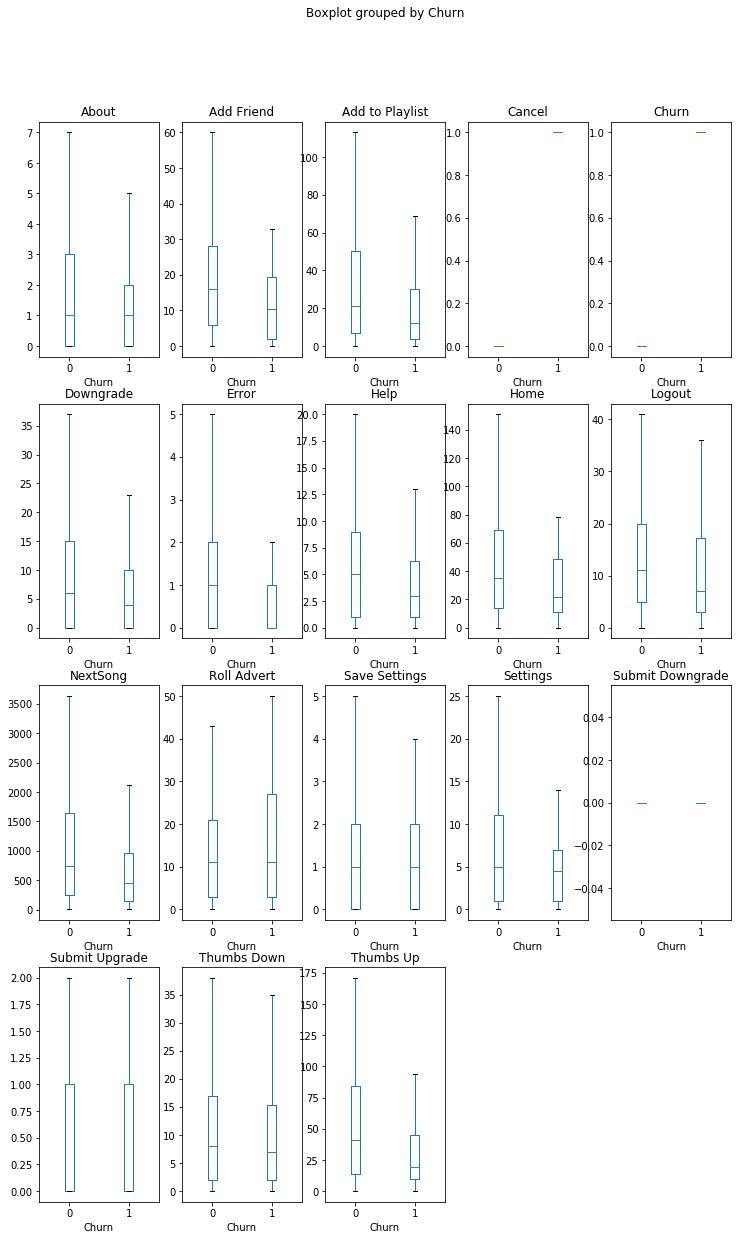

In [135]:
# As the statistic describtions of the two sets of data can be hard to comapare when looking at numbers, the boxplots of each of the columns is created
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 20))

for i in range(1,19):
    ax = fig.add_subplot(4,5,i)
    pandasPivot.boxplot(pandasPivot.columns[i].format(), ax=ax, grid=False,  by='Churn', showfliers=False);

## Conclusion

Visual inspection of the above graph shows that the folling features have the largest differnece in their boxplots. Thereforee, these will be used as the bases for our feature selection.

- Visits to the about page
- Adding friends
- Adding to playlist
- Visiting the help page
- Visiting the Home Page
- Playing a song
- Viewing the Settings page
- Giving Thums Up
- Upgrading

# Feature Engineering

Now that the features have been explored, it is time to extract the features. 

The pivot table above actually does give a very decent first version of a feature vector

Two version of features are used. For the first version, the events from the pivot table are used.

For the second version, the number of sessions, and the amount of days since a users first and last event are also used.

In [44]:
# V1 - A pivot table of the amount of events per user
featureDf = df.groupby(["userId"]).pivot("page").count().na.fill(0)

# Join in churn as label
featureDf = featureDf.withColumn("label", featureDf["Cancellation Confirmation"])

In [45]:
# V2 - Adding days and sessions 

In [46]:
# Create days Df 
minDf = df.select(["userId", "ts"]).groupby("userId").min("ts")
maxDf = df.select(["userId", "ts"]).groupby("userId").max("ts")
daysCount = minDf.join(maxDf, on="userId").withColumn("days", (col("max(ts)")-col("min(ts)")) / (1000*60*60*24)).select(["userId", "days"])

# Join in days count
featureDf = featureDf.join(daysCount,on="userId")

In [47]:
# Create sessions Df 
sessionCount = df.select(["userId", "sessionId"]).drop_duplicates()\
.groupby("userId").count().withColumnRenamed("count", "sessions")

# Join in session count
featureDf = featureDf.join(sessionCount,on="userId")

In [48]:
featureDf.take(1)

[Row(userId='100010', About=1, Add Friend=4, Add to Playlist=7, Cancel=0, Cancellation Confirmation=0, Downgrade=0, Error=0, Help=2, Home=11, Logout=5, NextSong=275, Roll Advert=52, Save Settings=0, Settings=0, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=5, Thumbs Up=17, Upgrade=2, label=0, days=44.21780092592593, sessions=7)]

# Training and Evaluation

The features have now been defined and the dataset is ready.

The training will be performed using pipelines, as they give great flexibility in switching out different parts of the pipeline, and it enables easy parameter tuning.

When working in this workspace, the data will be split into a training and test set, which will allow us to experiment with differnet models, and ensure that all of the spark commands work as expected.

When workign with the large datast in the cluster, an additional validation set will be created, which will be used to calculate the performance of the final model.

For this specific model, the F1 score is used as the performance indicator. The dataset is skewed towards non-churning users, and as such, a hugh accuracy can easily be achived by guessing that no-one will churn. The F1 score add a penalty to this kind of behaviour.

In [58]:
# Defining Evaluation function
f1Evaluator = MulticlassClassificationEvaluator(metricName="f1")

def EvaluatePredictions(predictions):
    '''
    input - predictions a spark dataframe with a "label" and "prediction column"
    output - prints a F1 evaluation score and a confusion matrix for the prediction results
    '''
    print(f"F1: {f1Evaluator.evaluate(predictions)}")
    
    print("Confusion Matrix:")
    predictions.groupby("label").pivot("prediction").count().show()

In [51]:
# Split data into train and test set
training, test = featureDf.randomSplit([0.8, 0.2])

In [53]:
# Construct Pipeline

# Create vector from feature data
a = VectorAssembler(inputCols=["sessions", "days", "About", "Add Friend", "Add to Playlist", "Help", "Home", "NextSong", "Settings", "Thumbs Up", "Upgrade"], outputCol="Features")

# Scale each column using MinMaxScaler
s = MinMaxScaler(inputCol="Features", outputCol="ScaledFeatures")

# Select a classifier 
rf = GBTClassifier(featuresCol="ScaledFeatures")
#rf = RandomForestClassifier(featuresCol="ScaledFeatures")
#rf = LinearSVC(featuresCol="ScaledFeatures")

# Consturct pipeline
pipeline = Pipeline(stages=[a, s, rf])

In [55]:
# Fit pipeline on training data
pipeModel = pipeline.fit(training)

In [56]:
# Calculate predictions and evaluate model on predicted data data
predictions = pipeModel.transform(training)
EvaluatePredictions(predictions)

F1: 1.0
Confusion Matrix:
+-----+----+----+
|label| 0.0| 1.0|
+-----+----+----+
|    0| 138|null|
|    1|null|  42|
+-----+----+----+



In [57]:
tPredictions = pipeModel.transform(test)
EvaluatePredictions(tPredictions)

F1: 0.7660249477251425
Confusion Matrix:
+-----+---+---+
|label|0.0|1.0|
+-----+---+---+
|    0| 28|  7|
|    1|  4|  6|
+-----+---+---+



# Results

The above steps works as a Proof of concept for the steps that should be performed the full dataset in the cluster. 

Preliminary results on this tiny dataset shows that the GBTClassifier has the best performance, but the testset is so small, that it is very hard to conclude anything. 

For the results of the final tuning, have a look at the results part of the readme